<a href="https://colab.research.google.com/github/daqichen/CIFAR10/blob/main/Model_with_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regularized Model with Data Augmentation

The following model is identical to the regularized model. However, the data is preprocessed before training. Existing samples in the training set are copied, modified, and re-inserted into the training set. Modifications to examples include shifting along the x-axis, shifting along the y-axis, and reflecting across the y-axis. The model is trained over 150 epochs using the Adam optimizer. It achieves a prediction accuracy of 82.99% on the validation set.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [ ]:
def data_loader(test=False):
  # load dataset
  (trainX, trainY), (testX, testY) = cifar10.load_data()
  # normalize x values
  trainX, testX = trainX.astype('float32')/255.0, testX.astype('float32')/255.0
  # one hot encode y values
  trainY, testY = to_categorical(trainY), to_categorical(testY)
  if (test):
    # return train set and test set
    return trainX, trainY, testX, testY
  else:
    # randomly sample 20% of data from train set
    mask_indices = np.random.choice(np.arange(trainX.shape[0]), size=int(trainX.shape[0] * 0.2), replace=False)
    mask_arr = np.zeros(trainX.shape[0])
    mask_arr[mask_indices] = 1
    # create validation set using random sample
    valX, valY = trainX[mask_arr == 1], trainY[mask_arr == 1]
    # remove random sample from train set
    trainX, trainY = trainX[mask_arr == 0], trainY[mask_arr == 0]
    # return train set and validation set
    return trainX, trainY, valX, valY

In [ ]:
def data_generator(trainX, trainY, batch_size=64, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True):
  # create data iterator
  data_gen = ImageDataGenerator(width_shift_range=width_shift_range, height_shift_range=height_shift_range, horizontal_flip=horizontal_flip)
  data_iter = data_gen.flow(trainX, trainY, batch_size=batch_size)
  # calculate steps per epoch
  steps_per_epoch = int(trainX.shape[0]/batch_size)
  # return data iterator and steps per epoch
  return data_iter, steps_per_epoch

In [ ]:
# define ConvNet model
def model(optimizer=Adam(), loss='categorical_crossentropy'):
  # initialize model
  model = Sequential()
  # add layers to model
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.3))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='softmax'))
  # compile model
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  return model

In [ ]:
# display training metrics and plot learning curves
def training_summary(history, loss, accuracy, test=False):
  # define x-axis of plots
  epochs = np.arange(len(history.history['loss'])) + 1
  # determine if evaluating performance on test set or validation set
  label = 'test' if test else 'validation'
  plt.figure(figsize=(15,30))
  # plot losses
  plt.subplot(621)
  plt.tight_layout()
  plt.title('Cross-Entropy Loss', fontsize=16)
  plt.xlabel('Epoch', fontsize=14)
  plt.ylabel('Loss', fontsize=14)
  plt.plot(epochs, history.history['loss'], color='blue', label='train')
  plt.plot(epochs, history.history['val_loss'], color='orange', label=label)
  plt.legend(loc='upper left')
  # plot accuracies
  plt.subplot(622)
  plt.tight_layout()
  plt.title('Classification Accuracy', fontsize=16)
  plt.xlabel('Epoch', fontsize=14)
  plt.ylabel('Accuracy', fontsize=14)
  plt.plot(epochs, history.history['accuracy'], color='blue', label='train')
  plt.plot(epochs, history.history['val_accuracy'], color='orange', label=label)
  plt.legend(loc='upper left')
  # print final loss and accuracy
  print(f'{label} loss: {loss:.3f} - {label} accuracy: {accuracy:.3f}')

In [ ]:
def predict(model, examples, label_map, transform=lambda x: (255*x).astype('uint8')):
  # make predictions based on example data
  predictions = [label_map[np.argmax(prediction)] for prediction in model.predict(examples)]
  # denormalize image data
  examples = transform(examples)
  for i in range(len(predictions)):
    plt.subplot(6,2,i+3)
    plt.tight_layout()
    # remove axis labels and ticks
    ax = plt.gca().axes
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    # display prediction
    plt.xlabel(predictions[i], fontsize=16)
    # display image
    plt.imshow(examples[i])

In [ ]:
# train the model and evaluate its performance
def train(data_loader, model, optimizer=Adam(), loss='categorical_crossentropy', epochs=100, batch_size=64, test=False, verbose=False):
  # load dataset
  trainX, trainY, valX, valY = data_loader(test=test)
  # define model
  model = model(optimizer=optimizer, loss=loss)
  # fit model
  data_iter, steps_per_epoch = data_generator(trainX, trainY, batch_size=batch_size)
  history = model.fit(data_iter, steps_per_epoch=steps_per_epoch, epochs=epochs, batch_size=batch_size, validation_data=(valX, valY), verbose=verbose)
  # evaluate model
  loss, acc = model.evaluate(valX, valY)
  # summarize training
  training_summary(history, loss, acc, test=test)
  # make predictions
  label_map = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
  predict(model, valX[:10], label_map)

170508288/170498071 [==============================] - 6s 0us/step
Epoch 1/150
625/625 [==============================] - 41s 50ms/step - loss: 1.9825 - accuracy: 0.2581 - val_loss: 1.5815 - val_accuracy: 0.4264
Epoch 2/150
625/625 [==============================] - 30s 48ms/step - loss: 1.6028 - accuracy: 0.4105 - val_loss: 1.3019 - val_accuracy: 0.5237
Epoch 3/150
625/625 [==============================] - 31s 50ms/step - loss: 1.4147 - accuracy: 0.4878 - val_loss: 1.1196 - val_accuracy: 0.5917
Epoch 4/150
625/625 [==============================] - 32s 51ms/step - loss: 1.2919 - accuracy: 0.5370 - val_loss: 1.0566 - val_accuracy: 0.6078
Epoch 5/150
625/625 [==============================] - 31s 50ms/step - loss: 1.2000 - accuracy: 0.5753 - val_loss: 1.0702 - val_accuracy: 0.6158
Epoch 6/150
625/625 [==============================] - 30s 49ms/step - loss: 1.1296 - accuracy: 0.6019 - val_loss: 0.9211 - val_accuracy: 0.6685
Epoch 7/150
625/625 [==============================] - 33s 53ms

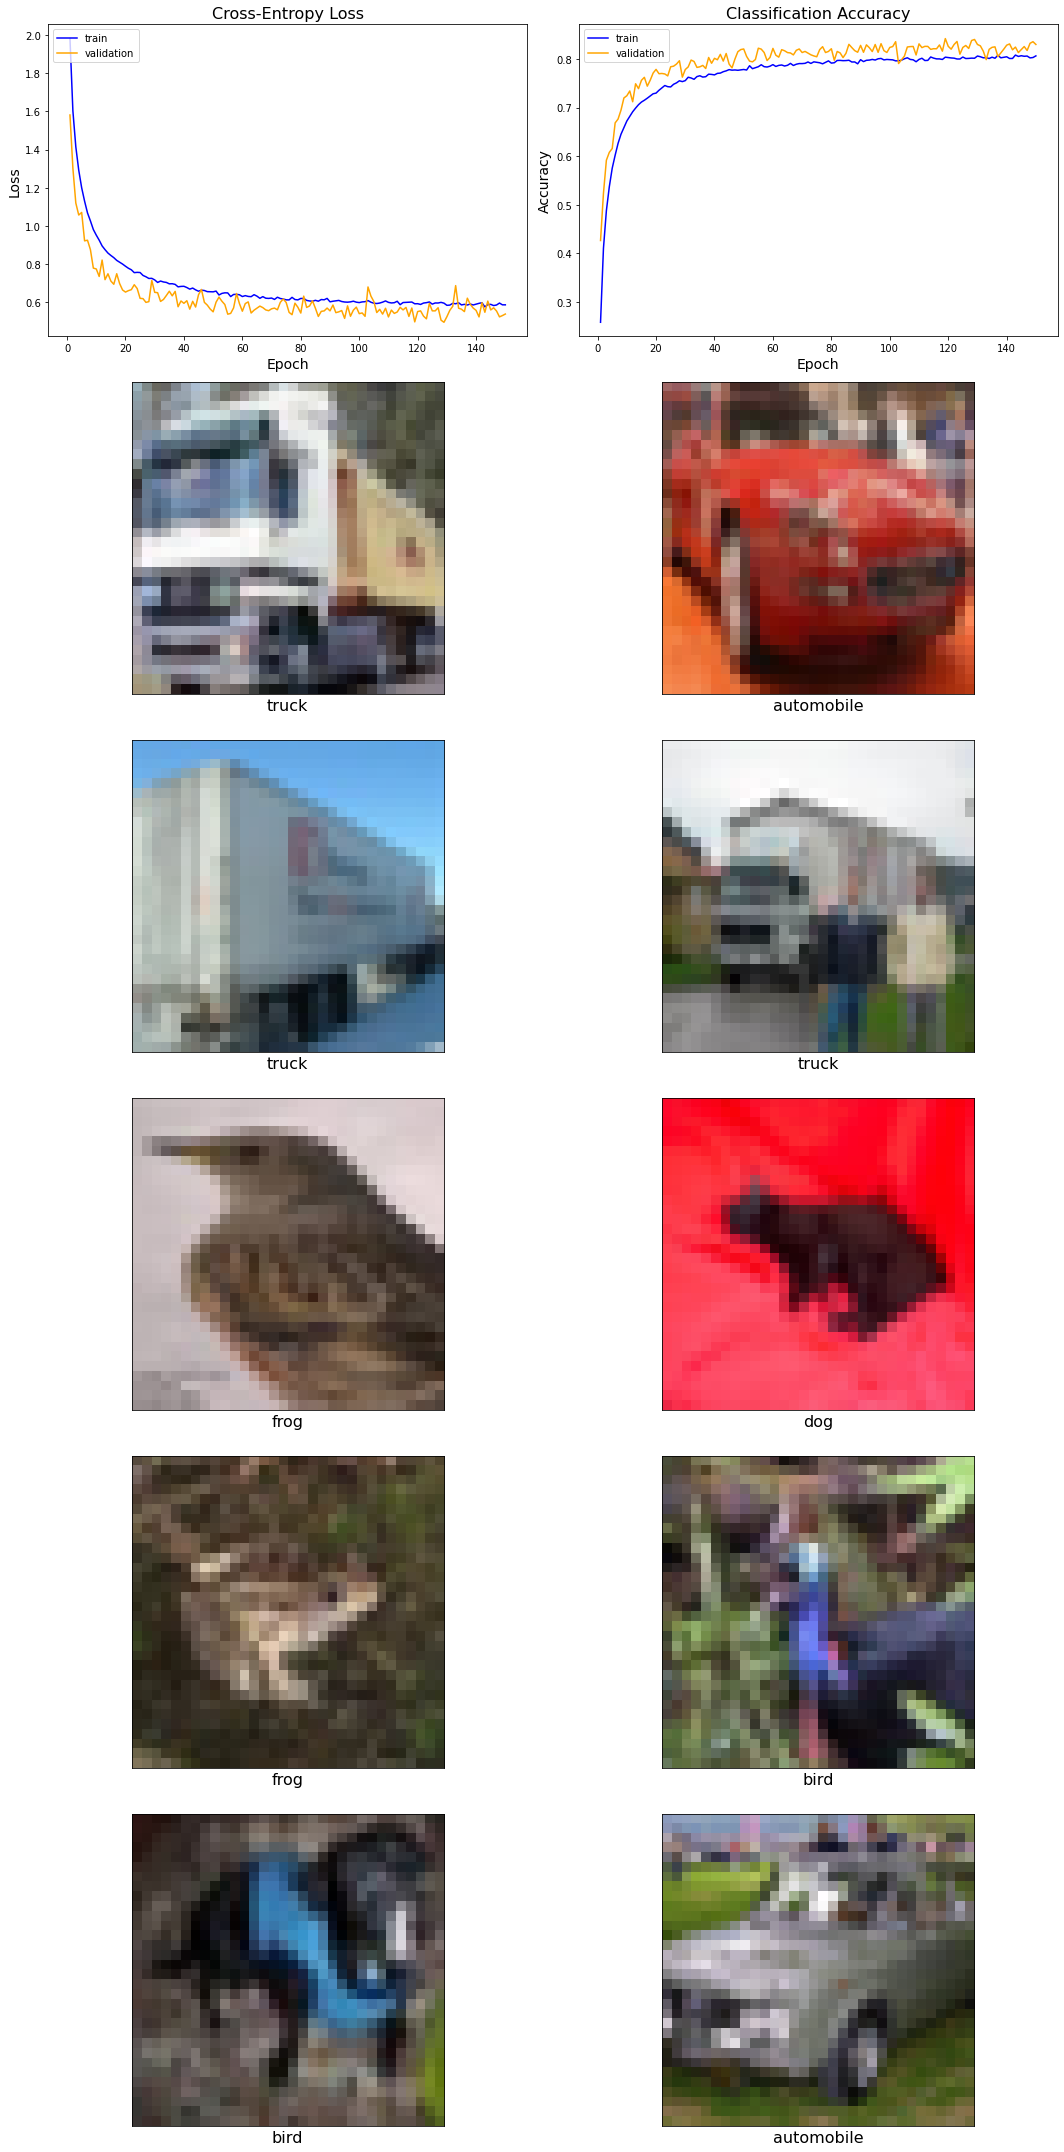

In [ ]:
train(data_loader=data_loader, model=model, epochs=150, verbose=True)